<a href="https://colab.research.google.com/github/dssp-ethz/DSSP-Illustrations/blob/main/LMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LMS Algorithm
We wish to estimate $X$ from some signal $Y$ using a (causal) Wiener filter, i.e.
$$\hat{X}[k] = \sum\limits_{n=0}^N h_k [n] Y [k-n]$$

We calibrate the filter in the adaptive mode, where we actually know $X$. We use the update formula:

$$\begin{pmatrix} h_{k+1}[0]\\h_{k+1}[1]\\ \vdots\\h_{k+1}[N] \end{pmatrix} = \begin{pmatrix} h_{k}[0]\\h_{k}[1]\\ \vdots\\h_{k}[N] \end{pmatrix} + \beta \left( X[k] - \hat{X}[k] \right) \begin{pmatrix} Y[k-0]\\Y[k-1]\\ \vdots\\Y[k-N] \end{pmatrix}$$

where $\beta$ is an adjustable learning parameter.

In [1]:
pip install pydsm

     |████████████████████████████████| 552kB 7.6MB/s 
  Created wheel for pydsm: filename=pydsm-0.14.0.0-cp37-cp37m-linux_x86_64.whl size=684639 sha256=720733e5468ab671f848b890af5ff04ca29a5fcc3b2ad5ad4936df844c6bdc38
  Stored in directory: /root/.cache/pip/wheels/7d/10/8c/8983ab80da463bab42f455c100dbf62c47fba0b6650f6c22f6
Successfully built pydsm


In [2]:
!gdown https://drive.google.com/uc?id=1-nxgfNaJPeB88X_kE5T2xDqiGI5T2I1u
!gdown https://drive.google.com/uc?id=1937_NrN8dHRPEsAamOn7v6hBSWG1cwzt

Downloading...
From: https://drive.google.com/uc?id=1-nxgfNaJPeB88X_kE5T2xDqiGI5T2I1u
To: /content/signals.py
100% 5.55k/5.55k [00:00<00:00, 11.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1937_NrN8dHRPEsAamOn7v6hBSWG1cwzt
To: /content/filters.py
100% 2.53k/2.53k [00:00<00:00, 6.69MB/s]


In [3]:
from pydsm.ft import idtft
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
%matplotlib inline
import signals
import filters
#-------------------------------------------------------------------------------

betaG = 0.05
NG = signals.nG.size//2 #Filter size
sigmaG = 1 #gaussian noise standard deviation
logPlotG = False

signals.widget()
filters.widget()

def update_sigma(sigma):
  global sigmaG
  sigmaG = sigma

widgets.interact(update_sigma,
    sigma = widgets.FloatSlider(
    value=0.05,
    min=0,
    max=0.1,
    step=0.01,
    description='sigma (noise)'))

#filter h
def h(t):
  return np.real(idtft(filters.H, t, fs = 2*np.pi)) #sets f_s such that f=Omega

#noise
def w(t):
  return np.random.normal(0, sigmaG, 1)[0]

#transmitted signal
def xx():
  return signals.time_domain_signal_long()

#received signal
def yy():
  #convolution in computer is finite. Restrict signals (and filters) to nG to be able to perform computations.
  u_ = xx()
  h_ = [h(t) for t in signals.nG]
  w_ = [w(t) for t in np.arange(4*signals.nG.size-1)] #result of convolution has dimension (N+M-1) i.e. (nG.size+nG.size-1) = 2*nG.size-1
  r_ = (np.convolve(u_,h_) + w_)
  delta = len(r_) - len(u_)
  return r_[delta//2: -delta//2]

#estimated signal during training process
def ee(h):
  e = [np.convolve(h[k], yy())[k] for k in range(len(h))]
  delta = len(yy()) - len(e)
  return [0]*delta + e #crops result to right size

#estimated signal after training process
def eef(h):
  e = [np.convolve(h[-1], yy())[k] for k in range(len(h))]
  delta = len(yy()) - len(e)
  return [0]*delta + e #crops result to right size

interactive(children=(Dropdown(description='signal type', options=('unit step', 'unit impulse', 'ramp', 'expon…

interactive(children=(Dropdown(description='filter type', options=('low pass', 'high pass', 'band pass', 'all …

interactive(children=(FloatSlider(value=0.05, description='sigma (noise)', max=0.1, step=0.01), Output()), _do…

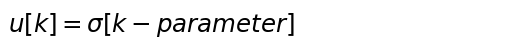

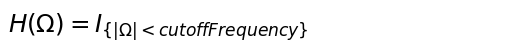

In [4]:
signals.display_signal_selection(continuous=False)
filters.display_filter_selection(continuous=False)

$u$ describes one possible realization of $X$ to which $h$ is applied prior to the addition of white noise.

You may select a signal, which is then filtered for transmission over a channel. The channel introduces some noise which you can adjust here as well. Will we be able to deduce the original signal?

In [5]:
def plot_time():
  t1_values = np.arange(3*np.min(signals.nG), 3*np.max(signals.nG)+3)
  t2_values = np.arange(3*np.min(signals.nG), 3*np.max(signals.nG)+3)

  fig = plt.figure(figsize=(30, 8))

  ax1 = fig.add_subplot(1, 2, 1)
  ax1.grid()
  ax1.set_xlabel('$k$', fontsize=14)
  ax1.set_ylabel('$x[k]$', fontsize=14)
  ax1.axis(xmin=t1_values[0], xmax=t1_values[-1])
  if logPlotG == False:
    ax1.axis(ymin=-3, ymax=3)
  else:
    ax1.axis(ymin=0.1, ymax=3)
    ax1.set_yscale("log") 
  ax1.stem(t1_values, xx());

  ax2 = fig.add_subplot(1, 2, 2)
  ax2.grid()
  ax2.set_xlabel('$k$', fontsize=14)
  ax2.set_ylabel('$y[k]$', fontsize=14)
  ax2.axis(xmin=t2_values[0], xmax=t2_values[-1])
  if logPlotG == False:
    ax2.axis(ymin=-3, ymax=3)
  else:
    ax2.axis(ymin=0.1, ymax=3)
    ax2.set_yscale("log") 

  ax2.stem(t2_values, yy());

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


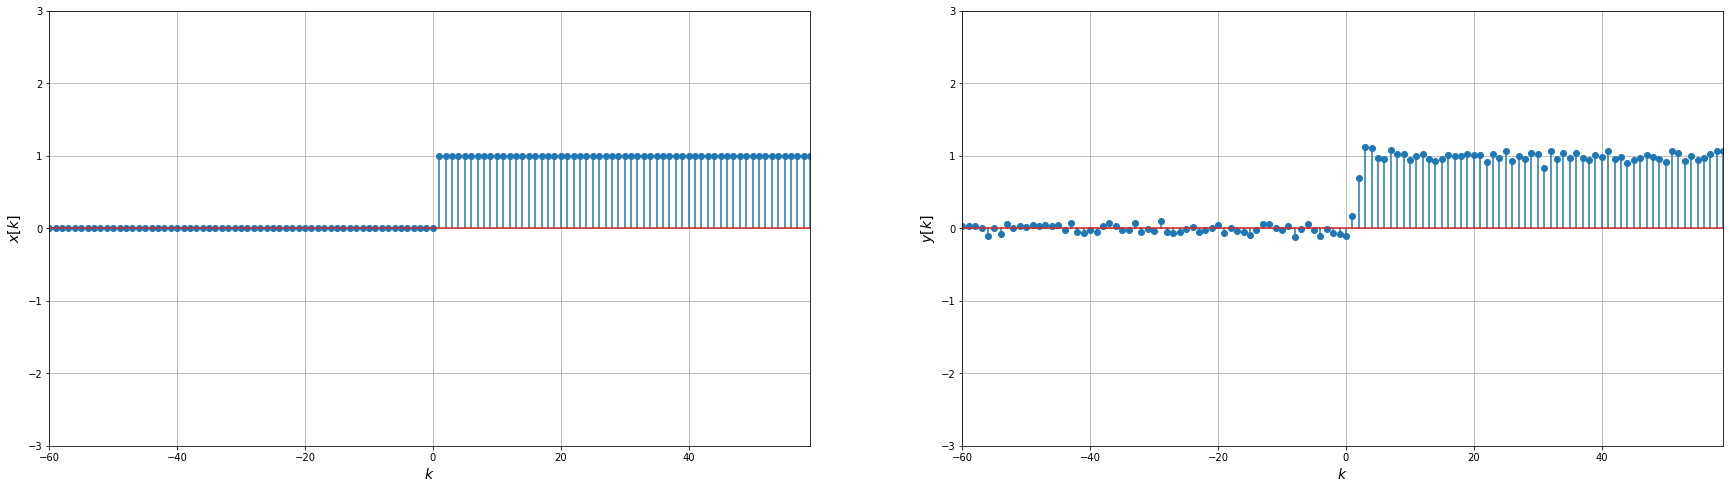

In [6]:
plot_time()

You should see the effects of the filter and noise on the original signal.

In [7]:
# input are numpy 1darrays: y, x, h_0 (initial weights); and a scalar: beta (learning rate)
# returns H (weight history) and E (Error history) (2darrays)
def LMS_adapt(y, x, h_0, beta):
  assert len(y) == len(x)
  assert len(h_0) >= 1
  assert len(y) >= len(h_0)

  H = np.array([h_0])
  E = np.array([])

  h = h_0

  for l in range(0, len(y) - len(h_0) + 1):
    yl = np.array([y[l + len(h_0)-1 - t] for t in range(0, len(h_0))]) #most recent values for y interval [l, l+len(h_0)-1] inverted
    el = x[l + len(h_0)-1] - np.dot(yl, h) #x[l + len(h_0)-1] - \hat{x}[l + len(h_0)-1]

    h = h + beta * el * yl
    
    H = np.append(H, [h], axis=0)
    E = np.append(E, [el], axis=0)

  return (H, E)

In [8]:
from mpl_toolkits.mplot3d import Axes3D

def plot_LMS():
  t1_values = np.arange(3*np.min(signals.nG), 3*np.max(signals.nG)+3)
  t2_values = np.arange(3*np.min(signals.nG), 3*np.max(signals.nG)+3)

  (H, E) = LMS_adapt(yy(), xx(), np.ones(NG), betaG)

  fig = plt.figure(figsize=(30, 8))

  ax1 = fig.add_subplot(1, 3, 1)
  ax1.grid()
  ax1.set_xlabel('$t$', fontsize=14)
  ax1.set_ylabel('$error[t]$', fontsize=14)
  ax1.axis(xmin=0, xmax=len(E))
  if logPlotG == False:
    ax1.axis(ymin=-10, ymax=10)
  else:
    ax1.axis(ymin=0.1, ymax=10)
    ax1.set_yscale("log") 
  ax1.stem(E);

  ax2 = fig.add_subplot(1, 3, 2)
  ax2.grid()
  ax2.set_xlabel('$t$', fontsize=14)
  ax2.set_ylabel('$squared\ error[t]$', fontsize=14)
  ax2.axis(xmin=0, xmax=len(E))
  if logPlotG == False:
    ax2.axis(ymin=-10, ymax=50)
  else:
    ax2.axis(ymin=0.1, ymax=50)
    ax2.set_yscale("log") 
  ax2.stem(E**2);

  ax3 = fig.add_subplot(1, 3, 3, projection='3d')
  ax3.grid()
  if logPlotG == True:
    ax3.set_yscale("log") 

  T, K = np.meshgrid(range(len(H[0])), range(len(H[:,1])))

  Xi = K.flatten()
  Yi = T.flatten()
  Zi = np.zeros(H.size)

  dx = 0.5 * np.ones(H.size)
  dy = 0.5 * np.ones(H.size)
  dz = H.flatten()

  ax3.set_xlabel('time t')
  ax3.set_ylabel('index k')
  ax3.set_zlabel('$h_t[k]$')

  ax3.bar3d(Xi, Yi, Zi, dx, dy, dz)

In [9]:
def update_parameters(N, beta, logPlot):
  global NG, betaG, logPlotG
  NG,  betaG, logPlotG = N, beta, logPlot

widgets.interact(update_parameters,
  N = widgets.IntSlider(
    value=signals.nG.size//2,
    min=1,
    max=signals.nG.size,
    description='N'),
  beta = widgets.FloatSlider(
    value=0.025,
    min=0,
    max=0.05,
    step=0.001,
    description='beta',
    readout_format ='.3f'),
  logPlot = widgets.Checkbox(
    value=False,
    description='logarithmic plot')
);


interactive(children=(IntSlider(value=20, description='N', max=40, min=1), FloatSlider(value=0.025, descriptio…

These are the filter parameter. $N$ selects the length of the equalization filter and thus its sophistication. $\beta$ is the learning rate of the LMS algorithm. Too little a learning rate and we never reach the optimum. Too large a learning rate and we diverge away from the optimum.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


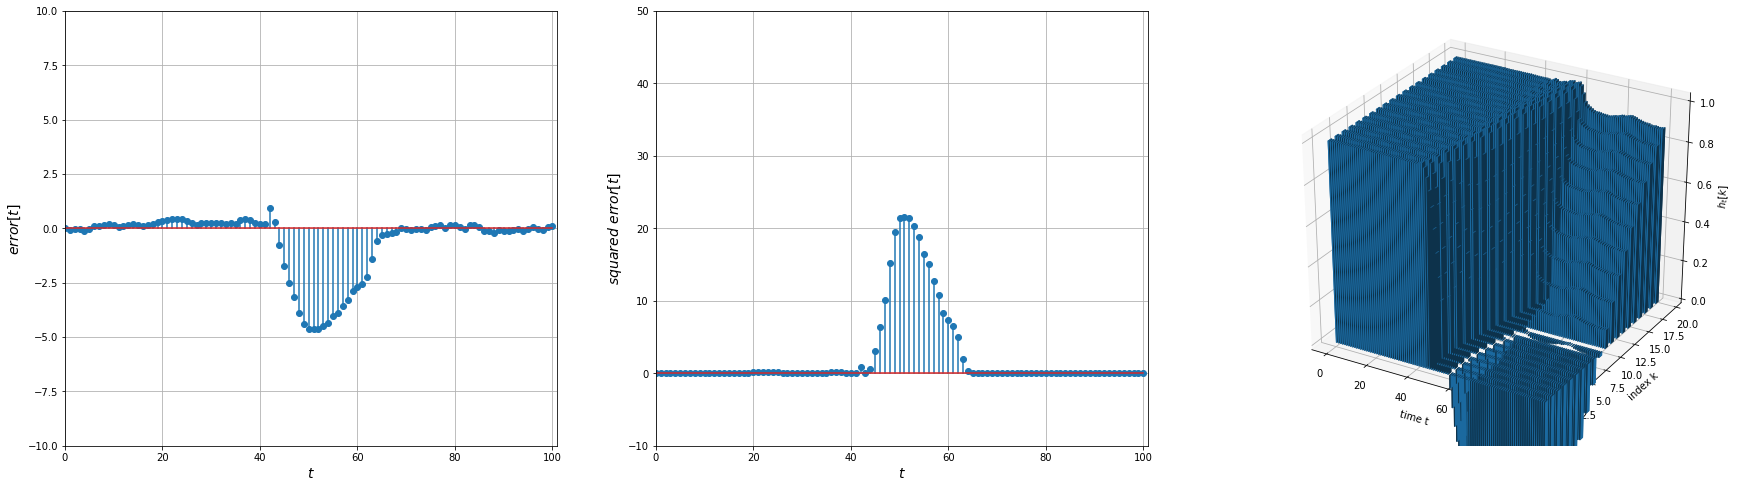

In [10]:
plot_LMS()

Hopefully the selected parameters gave you convergence. Note that LMS optimizes the squared error, however the absolute error is a useful tool to identify divergence if present. All the way to the right you can see the evolution of the filter coefficients.

In [11]:
def plot_estimated():
  t1_values = np.arange(3*np.min(signals.nG), 3*np.max(signals.nG)+3)
  t2_values = np.arange(3*np.min(signals.nG), 3*np.max(signals.nG)+3)

  fig = plt.figure(figsize=(30, 8))

  ax1 = fig.add_subplot(2, 2, 1)
  ax1.grid()
  ax1.set_xlabel('$k$', fontsize=14)
  ax1.set_ylabel('$x[k]$', fontsize=14)
  ax1.axis(xmin=t1_values[0], xmax=t1_values[-1])
  if logPlotG == False:
    ax1.axis(ymin=-3, ymax=3)
  else:
    ax1.axis(ymin=0.1, ymax=3)
    ax1.set_yscale("log") 
  ax1.stem(t1_values, xx());

  ax2 = fig.add_subplot(2, 2, 2)
  ax2.grid()
  ax2.set_xlabel('$k$', fontsize=14)
  ax2.set_ylabel('$y[k]$', fontsize=14)
  ax2.axis(xmin=t2_values[0], xmax=t2_values[-1])
  if logPlotG == False:
    ax2.axis(ymin=-3, ymax=3)
  else:
    ax2.axis(ymin=0.1, ymax=3)
    ax2.set_yscale("log") 

  ax2.stem(t2_values, yy());

  (H, E) = LMS_adapt(yy(), xx(), np.ones(NG), betaG)
  estimates = ee(H)
  t3_values = np.arange(3*np.min(signals.nG), 3*np.max(signals.nG)+3)

  ax3 = fig.add_subplot(2, 2, 3)
  ax3.grid()
  ax3.set_xlabel('$k$', fontsize=14)
  ax3.set_ylabel('$\hat{x}[k]$', fontsize=14)
  ax3.axis(xmin=t3_values[0], xmax=t3_values[-1])
  if logPlotG == False:
    ax3.axis(ymin=-3, ymax=3)
  else:
    ax3.axis(ymin=0.1, ymax=3)
    ax3.set_yscale("log") 

  ax3.stem(t3_values, estimates);

  estimates = eef(H)
  t4_values = np.arange(3*np.min(signals.nG), 3*np.max(signals.nG)+3)

  ax4 = fig.add_subplot(2, 2, 4)
  ax4.grid()
  ax4.set_xlabel('$k$', fontsize=14)
  ax4.set_ylabel('$\hat{x}[k]$', fontsize=14)
  ax4.axis(xmin=t3_values[0], xmax=t3_values[-1])
  if logPlotG == False:
    ax4.axis(ymin=-3, ymax=3)
  else:
    ax4.axis(ymin=0.1, ymax=3)
    ax4.set_yscale("log") 

  ax4.stem(t4_values, estimates);


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning 

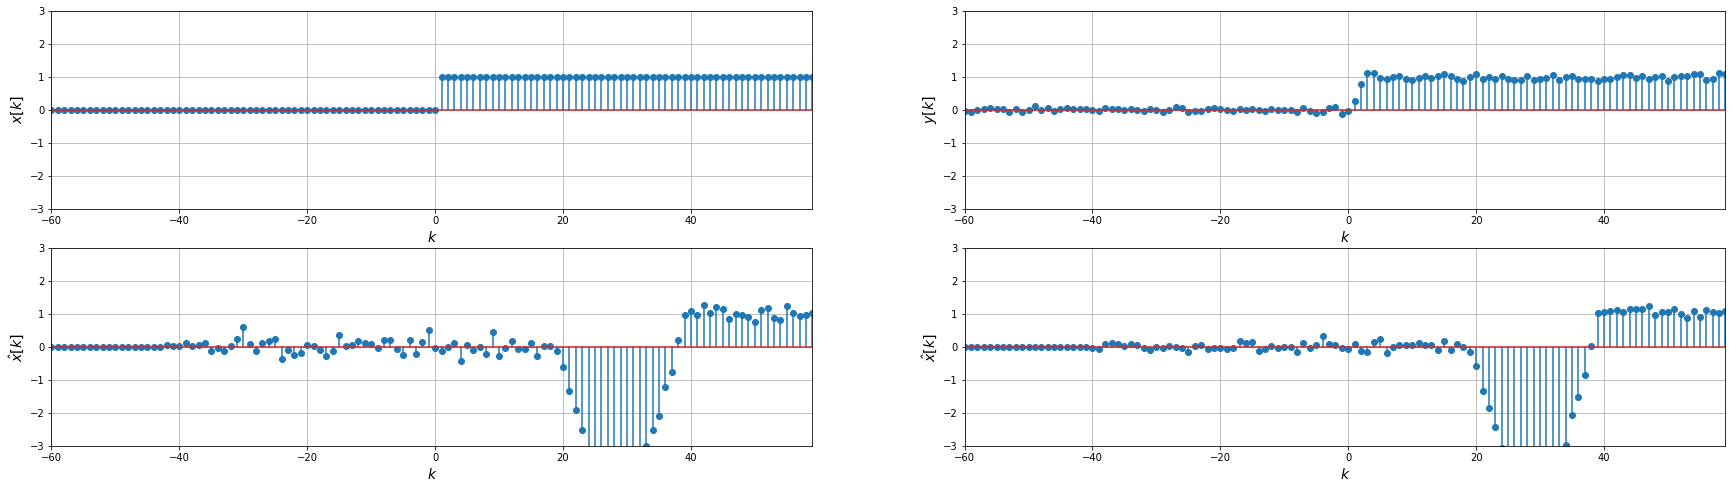

In [12]:
plot_estimated()

Here you can see the final results. On top the signal transmitted and received signal and below the estimate during training and the estimate if the filter was run over the data again after training is complete (with fixed coefficients). 